In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle
import datetime
from datetime import timedelta
from functools import reduce

%matplotlib inline

# Import local modules
import load_files as lf
import measurement_analysis as ma
import wrangling as wr
import utility as ut
import time

In [73]:
file_path = "/Users/blazejmanczak/Desktop/Q1/DataChallenge3/"
flow_data_DRU, level_data_DRU = lf.get_measurements(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150")
rain_data = lf.get_rain(file_path +"/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries")
data = lf.sdf(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

pickle_in = open("/Users/blazejmanczak/Desktop/Q1/DataChallenge3/ma_df_all", "rb")
df = pickle.load(pickle_in)

level_data = wr.clean_mes_data(df.level_data)
flow_data = wr.clean_mes_data(df.flow_data)

level_data_not_imputed = wr.clean_mes_data(df.level_data)
flow_data_not_imputed = wr.clean_mes_data(df.flow_data)
flow_data_index_timestamp = flow_data_not_imputed.set_index('TimeStamp').copy()

flow_data, level_data = wr.merge_flow_level(flow_data, level_data)

In [82]:
na_indices = flow_data.index[flow_data["Value"].isna()]
non_na_indices = flow_data.index[~flow_data["Value"].isna()]

Number of NaN's:  424439
Number of Non-NaN's:  2880599


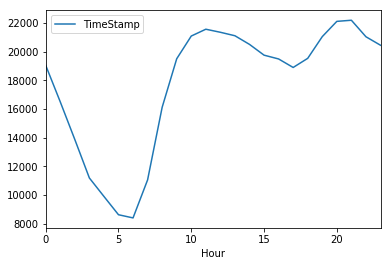

In [4]:
flow_data[['TimeStamp', 'Hour']].loc[na_indices].groupby('Hour').aggregate('count').plot()

print("Number of NaN's: ", len(na_indices))
print("Number of Non-NaN's: ", len(non_na_indices))

## Algorithm in words: 
- naturally every timestamp for which flow is NaN has an entry in the level data as the missing timestamp comes from there. Note that within the flow data itself we do not have NaN's.
- check if the level is increasing, decreasing, or around extremum. If increasing and in bounds of on/off level, then value for flow 0. If the level is decreasing, around extremum or above the on level:

- compute the mean flow given around this level (some neighboorhood, eg. +- 0.1) across all level data
- get the flow data corresponding to these levels when level is decreasing
- if the std is not larger than $\frac{1}{2} \cdot$ max(mean_flow, median_flow), plug this value in as impute prediction. Otherwise leave NA



In [133]:
def check_monotonicity(x, epsilon = 1):
    """ 
    Function that checks whether a list is increasing or
    decreasing with an epsilon terms that do not suit the pattern
    """
    dx = np.diff(x) # takes the difference of consecutive elements 
    positives = int(np.sum(np.array(dx) >= 0, axis=1) )
    negatives = int(dx.shape[1] - positives)
    
    if negatives >= dx.shape[1] - epsilon:
        return 'Decreasing'
    elif positives >= dx.shape[1] - epsilon:
        return 'Increasing'
    else:
        return 'Extremum' # or it's neighboorhood
   


def calc_monotonicity(data, horizon = 5, epsilon = 3):
    data = data.copy()
    
    time_start = time.time()
    data['Window'] = data\
        .apply(lambda x:[data['Value'][x.name-horizon : x.name+horizon+1]], axis=1)
    print("The computation of Window took {} seconds".format(round(time.time() - time_start, 3)))

    time_start = time.time()
    data['Monotonicity'] = data\
        .apply(lambda x: check_monotonicity(x['Window'], epsilon = epsilon), axis = 1)
    print("The computation of Monotonicity took {} seconds".format(round(time.time() - time_start, 3)))
    
    return data

### We see that epsilon is an important hyper parameter - the bigger it is, the less Extremums points we will have
Note that if epsilon >= horizon then no point willbe classified as extremum; it will just default to whatever comes first in the check_monotonicity function. In our case, we would like extremums to still be evaluated (if there is not too much variation in the prediction) as otherwise they will default to 0 too often. That is why in check_monotonicity function we first the if statement which results in 'Decreasing'.

In [134]:
level_data_not_imputed = calc_monotonicity(level_data_not_imputed, horizon = 5, epsilon = 5)
level_data_not_imputed.groupby('Monotonicity').count()

The computation of Window took 96.094 seconds
The computation of Monotonicity took 106.02 seconds


,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Window
Monotonicity,,,,,,,,,,,,,,,
Decreasing,433093,433093,433093,433093,433093,433093,433093,433093,433092,433092,433092,433093,433093,433093,433093
Increasing,446585,446585,446585,446585,446585,446585,446585,446585,446585,446585,446585,446585,446585,446585,446585


In [135]:
def fill_flow_apply(row, on_level, epsilon = 0.01, timestamp_index_flow = True,
                    level_data = level_data_not_imputed, flow_data = flow_data_not_imputed):
    """ 
    Function used in an apply method in fill flow function.
    It returns the a float prediction for the input as described above.
    
    Note that the solution is much faster if the flow data is indexed by timestamp.
    
    ~~~~~ INPUT  ~~~~~
    row:                  row from apply function 
    on_level:             The on level of the pump. Suggested 95% quantile of level value
    epsilon:              a distance from the level corresponding to the missing flow value to be considered
    timestamp_index_flow: boolean stating if the supplied flow_data has timestamp as an index (Recomennded)
    level_data:           not imputed level data
    flow_data:            not imputed flow data
    """
    
    level_row = level_data[level_data['TimeStamp'] == row['TimeStamp']]
    if len(level_row) == 0: # only for testing. In normal missing data we always have corresponding level
        return 'Fuuuuuuck'
    
    is_zero = ((level_row['Monotonicity'] == 'Increasing') & (level_row['Value'] < on_level))
    if is_zero.values[0]:
        return 0.0
    
    else: #decreasing or level is above on or around extremum
        level_value = level_row['Value'].values[0] # makes it a flow instead of a series
        
        time_start = time.time()
        same_level_timestamps = level_data[( abs(level_data['Value'] - level_value) < epsilon  ) &
                                 (level_data['Monotonicity'] != 'Increasing') ]['TimeStamp'] 
        #Take not only these timestamps but also the neighboorhooing timestamps for that level value
        
        
        try:
            if timestamp_index_flow: # Assuming the timestamp is the index [RECOMMENDED]
                flow_values = flow_data.loc[same_level_timestamps]['Value']
            else:
                flow_values = flow_data[flow_data['TimeStamp'].isin(list(same_level_timestamps.values))]['Value']
        except: # if there are no timestamps in flow(not_imputed) corresponding to the matching same_level_timestamps
            return None
            
            
        # Look at the certainty of the flow values
        mean_flow = np.mean(flow_values)
        std_flow = np.std(flow_values)
        median_flow = np.median(flow_values) # used to counter the systematic 
        
        if std_flow > (0.5 * mean_flow): # too much variation in the prediction
            return None
        else:
            return max(mean_flow, median_flow)  
        
        
def fill_flow(flow_data = flow_data, epsilon = 0.01, timestamp_index_flow = True,
              level_data = level_data_not_imputed, flow_data_not_imputed = flow_data_not_imputed): 
    """
    Function that applies fill_flow_apply (which operates on non-imputed data frames) to the missing values.
    Note that we need the merged data frame of flow and level as well here.
    """
    time_start = time.time()
    na_indices = flow_data.index[flow_data["Value"].isna()]
    print('{} NaN indices identified'.format(len(na_indices)))
    flow_data = flow_data[flow_data.index.isin(list(na_indices))]
    
    on_level = np.quantile(level_data_not_imputed['Value'], q = 0.95)
    
    flow_data['Value'] = flow_data.apply(lambda row: fill_flow_apply(row, on_level = on_level,\
                        epsilon = epsilon, timestamp_index_flow = timestamp_index_flow, \
                        level_data = level_data_not_imputed, flow_data = flow_data_not_imputed), axis = 1)
    print('The whole process took {} seconds'.format(round(time.time() - time_start, 2)))
    return flow_data

In [51]:
# Small test
#flow_data_index_timestamp = flow_data_not_imputed.set_index('TimeStamp').copy() done on top
a = flow_data.iloc[-1000:].copy()
a_answer = fill_flow(flow_data = a, epsilon= 0.005, flow_data_not_imputed=flow_data_index_timestamp)

## Evaluating the prediction model

In [136]:
# Borrowing a function from rainData& Level flow
def take_subset(start_date, end_date, level = level_data_DRU, flow = flow_data_DRU):
    #rain = rain.copy()
    level = level.copy()
    flow = flow.copy()
    
    #rain = rain[(rain['Start'] > start_date) & (rain['Start'] < end_date)]
    level = level[(level['TimeStamp'] > start_date) & (level['TimeStamp'] < end_date)]
    flow = flow[(flow['TimeStamp'] > start_date) & (flow['TimeStamp'] < end_date)]
    
    return level, flow 
 
#level, flow = take_subset('2018-05-10 17:00:00','2018-05-11 19:59:01', level=level_data_not_imputed, flow=flow_data_not_imputed)
level, flow = take_subset('2018-05-22 23:17:00','2018-05-24 04:30:01', level=level_data_not_imputed, flow=flow_data_not_imputed)

flow_dumb = flow.copy()
flow_dumb['Value'] = [np.nan] * len(flow_dumb['Value']) 
flow_dumb = fill_flow(flow_data = flow_dumb, epsilon= 0.005, flow_data_not_imputed=flow_data_index_timestamp)

18802 NaN indices identified
The whole process took 59.48 seconds


In [131]:
level_data_not_imputed[level_data_not_imputed['TimeStamp'] == '2018-04-30 03:05:44']

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Window,Monotonicity
148823,8150,2018-04-30 03:05:44,1.889727,1,2018-04-30,3,4,0,340.0,0.002941,-0.051127,0,0,1,"[[1.8386, 1.889727, 1.940854, 1.99333, 1.94085...",Decreasing


In [137]:
could_predict_indicies = flow_dumb[flow_dumb['Value']!= 'Fuuuuuuck'].index
flow_dumb_predicted = flow_dumb.loc[could_predict_indicies]
flow_dumb_predicted['TrueValue'] = flow.loc[could_predict_indicies]['Value']

flow_dumb_predicted['Error'] = (flow_dumb_predicted['TrueValue'] - flow_dumb.loc[could_predict_indicies]['Value'])

(736836.9583333334, 736837.1659837964)

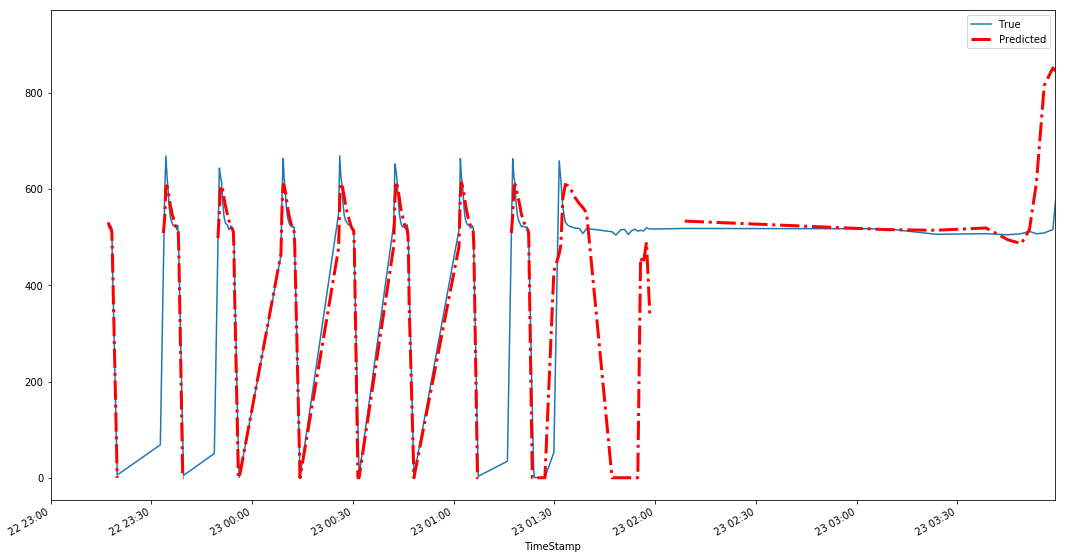

In [138]:
ax = flow_dumb_predicted.plot(x = 'TimeStamp', y = 'TrueValue', figsize = (18,10))
flow_dumb_predicted.plot(x = 'TimeStamp', y = 'Value', ax = ax, color = 'r',  linewidth = 3, linestyle = "-.")
ax.legend(['True', 'Predicted'])
ax.set_xlim(['2018-05-22 23:00:00','2018-05-23 03:59:01'])

In [139]:
could_predict_indicies = flow_dumb[flow_dumb['Value']!= 'Fuuuuuuck'].index
flow_dumb_predicted = flow_dumb.loc[could_predict_indicies]
flow_dumb_predicted['TrueValue'] = flow.loc[could_predict_indicies]['Value']

flow_dumb_predicted['Error'] = (flow_dumb_predicted['TrueValue'] - flow_dumb.loc[could_predict_indicies]['Value'])

In [140]:
print("Error:", flow_dumb_predicted['Error'].mean(), "and its std:", flow_dumb_predicted['Error'].std())

Error: 14.611747105278813 and its std: 95.97837761899697


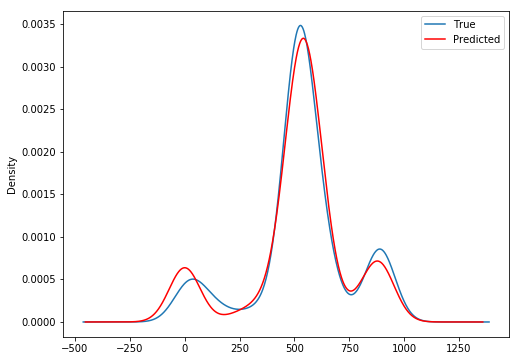

In [141]:
# distributions
ax = flow_dumb_predicted['TrueValue'].plot(kind = 'density', figsize = (8,6))
flow_dumb_predicted['Value'].plot(kind = 'density', ax = ax, color = 'r')
ax.legend(['True', 'Predicted'])

In [142]:
flow_dumb_predicted[flow_dumb_predicted['Error'] > 200] 

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Flow,max,min,Dry,TrueValue,Error
582191,8150,2018-05-23 01:47:10,0,1,2018-05-23,1,5,0,5.0,0.2,0.709987,0,1,1,511.1905,511.19
582205,8150,2018-05-23 01:48:20,0,1,2018-05-23,1,5,0,5.0,0.2,0.700462,0,1,1,504.3327,504.333
582222,8150,2018-05-23 01:49:45,0,1,2018-05-23,1,5,0,5.0,0.2,0.715569,0,0,1,515.2097,515.21
582236,8150,2018-05-23 01:50:55,0,1,2018-05-23,1,5,0,5.0,0.2,0.716756,1,0,1,516.0641,516.064
582249,8150,2018-05-23 01:52:00,0,1,2018-05-23,1,5,0,5.0,0.2,0.702022,0,1,1,505.4559,505.456
582261,8150,2018-05-23 01:53:00,0,1,2018-05-23,1,5,0,5.0,0.2,0.713266,0,0,1,513.5515,513.552
582272,8150,2018-05-23 01:54:00,0,1,2018-05-23,1,5,0,5.0,0.2,0.717093,1,0,1,516.3067,516.307
582282,8150,2018-05-23 01:54:50,0,1,2018-05-23,1,5,0,5.0,0.2,0.711844,0,1,1,512.5276,512.528
592164,8150,2018-05-23 15:53:07,688.876,1,2018-05-23,15,5,0,5.0,0.2,1.270279,0,1,1,914.6009,225.724


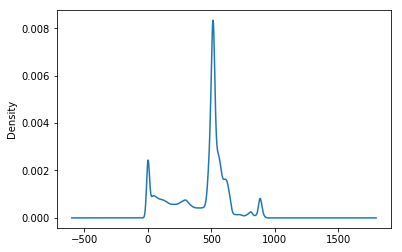

In [81]:
#flow_data_not_imputed['Value'].plot(kind = 'density') 
# We see that the distribution of the sample is similiar to that of 

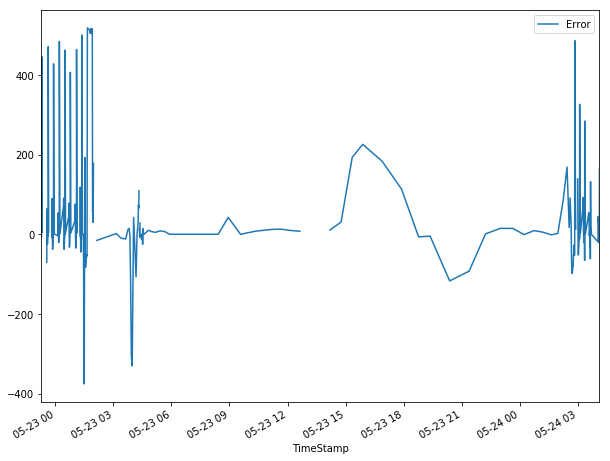

In [114]:
flow_dumb_predicted.plot(x = 'TimeStamp', y = 'Error', figsize = (10,8)) # error plot for all numerical predictions

(-250, 250)

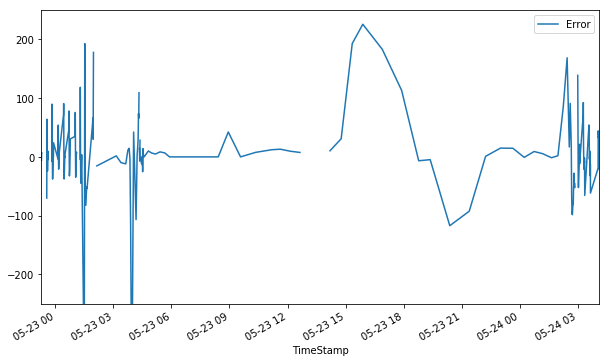

In [115]:
ax = flow_dumb_predicted[flow_dumb_predicted['Value'] != 0].plot(x = 'TimeStamp', y = 'Error', figsize = (10,6))
ax.set_ylim(-250, 250) # error for non-zero numerical predictions